In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import proplot as pplt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import grid_points as gp
import pickle
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
import glob

In [3]:
shape_library = ['rows', 'columns', 'rectangle', 'triangle', 'circle', 'ellipse', 'random_squares_small','random_squares_large', 'organic']
coverage_range = np.arange(10,91,5)
grid_codes = ['a1','a2','a3','a4','b1','b2','c1','c2']
frameworks = ['a1','a2','a3','a4','b1','b2','c1m','c1s','c1c','c2m','c2s','c2c']
irradiance_levels = [200,400,600,800,1000]

In [171]:
results_dict = {}
for irradiance_level in irradiance_levels:
    Tcell = 25
    results_fp = f"results/log_simulations_{irradiance_level}W_{Tcell}C.txt"

    df = pd.read_csv(results_fp)

    def process_result_key(key):
        key_list = key.split("_")
        shape = "_".join(key_list[0:len(key_list)-2])
        
        coverage = key_list[len(key_list)-2]
        scenario = key_list[-1]
        
        return shape, coverage, scenario

    s = df['result_key'].apply(lambda x: process_result_key(x))
    s = s.apply(pd.Series)
    s = s.rename(columns={0:'mask',
                            1:'coverage_factor',
                            2:'scenario'})

    results = pd.concat([df,s],axis=1)
    results['coverage_factor'] =results['coverage_factor'].astype(int)
    results['kWh'] = results['surface_power [wh]'] / 1000
    results_dict[irradiance_level] = results

# General Line Plots

In [ ]:
irradiance_level = 1000
results = results_dict[irradiance_level]
for shape in shape_library:
    plot = results[results['mask']==shape].pivot_table(index='coverage_factor', 
                                                        columns='scenario', 
                                                        values='kWh')
    colors_simple = pplt.get_colors("Greens",6)[1:5] + pplt.get_colors("Browns1",4)[1:3]
    colors_complex = pplt.get_colors("Blue",7)[1::2] + pplt.get_colors("Reds",7)[1::2]


    fig,axe = pplt.subplots(facecolor="white",figsize=(10,5))
    ax = axe[0]

    ax.line(plot.index, 
            plot[[c for c in plot.columns if "c" not in c]],
            ls="solid",
            lw=2,
            cycle=pplt.Cycle(colors_simple))

    ax.line(plot.index, 
            plot[[c for c in plot.columns if "c" in c]],
            ls="dashed",
            cycle=pplt.Cycle(colors_complex, lw=[6,5,4,3,2,1]))
    ax.tick_params(direction='in',pad=4.25,
                left=True,top=True,right=True,bottom=True,
                )
    ax.minorticks_off()
    ax.grid(linestyle='dashed')
    ax.format(ylabel='Surface Power (kWh)',
            ltitle=f'Simulation Results ({irradiance_level}) (Mask={shape})',
            xticklabelpad=10,
            xgrid=False,
            xlocator=5,
            ylocator=2,
            xlim=(10,90),
            ylim=(0,28))



    fig.legend(loc='right',ncols=1)
    
    fig.savefig(f"/Users/jmccarty/Nextcloud/Projects/17_framework/results/line_plots/{irradiance_level}W__{Tcell}C_{shape}.png",dpi=144)
    
    pplt.close()

In [ ]:
irradiance_level = 1000
results = results_dict[irradiance_level]
plot = results[['mask','coverage_factor','kWh']].copy()

def change_mask_name_str(mask):
    if "random" in mask:
        return mask.replace("_","\n").capitalize()
    else:
        return mask.capitalize() 
    
plot['mask'] = plot['mask'].apply(lambda x: change_mask_name_str(x))

plot["coverage_factor"] = plot["coverage_factor"].astype(str) + "%"
fig,axe = plt.subplots(figsize=(12,6), facecolor="white")
# ax= axe[0]
g = sns.boxplot(x="mask", y="kWh",
            hue="coverage_factor",
            data=plot, ax =axe, 
            # palette=sns.color_palette(pplt.get_colors(pplt.Colormap(["#FFCC00","#DD0000","#000000"]),plot['coverage_factor'].nunique())),
            palette=sns.color_palette("greys", 20),
            )
# sns.despine(offset=10, trim=True) 
# fig.legend(loc='right', title="Coverage")
g.set(xlabel=None)
g.set(ylim=(0,17))
axe.get_legend().remove()
plt.xticks(rotation=0)
# axe.format(xrotation=45)
plt.legend(bbox_to_anchor=(1.01, 0.83), title="Coverage")
plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"/Users/jmccarty/Nextcloud/Projects/17_framework/results/box_plots/{irradiance_level}W_{Tcell}C_boxplot_masks_coverage.pdf")

## Does Range get smaller with coverage

### all

In [ ]:
irradiance_level = 1000
results = results_dict[irradiance_level]
range_study = results.copy()
coverage_range_results = []

for mask in range_study['mask'].unique():
    range_dict[mask] = {}
    mask_slice = range_study[range_study['mask']==mask]
    for cf in mask_slice['coverage_factor'].unique():
        mask_cf_slice = mask_slice[mask_slice['coverage_factor']==cf]
        output_range = mask_cf_slice['kWh'].max() - mask_cf_slice['kWh'].min()
        coverage_range_results.append((cf,output_range))
        
test_df = pd.DataFrame(coverage_range_results)


stats.pearsonr(test_df[0].astype(float),test_df[1])

### per mask

In [ ]:
irradiance_level = 1000
results = results_dict[irradiance_level]
range_study = results.copy()
# range_study['coverage_factor'] = range_study['coverage_factor'].astype(float)

range_dict = {}

for mask in range_study['mask'].unique():
    range_dict[mask] = {}
    mask_slice = range_study[range_study['mask']==mask]
    for cf in mask_slice['coverage_factor'].unique():
        mask_cf_slice = mask_slice[mask_slice['coverage_factor']==cf]
        output_range = mask_cf_slice['kWh'].max() - mask_cf_slice['kWh'].min()
        range_dict[mask][cf] = output_range
        
range_df = pd.DataFrame(range_dict)

range_corr_dict = {}
range_corr_dict_p = {}
for mask in range_study['mask'].unique():
    test_corr = range_df[mask].reset_index()
    test_corr['index'] = test_corr['index'].astype(float)
    test_results = stats.pearsonr(test_corr['index'].astype(float),test_corr[mask])
    range_corr_dict[mask] = test_results.statistic # test_results test_corr.corr()[mask].loc['index']
    range_corr_dict_p[mask] = test_results.pvalue
    

In [ ]:
range_df.plot()

In [ ]:
corr_scores = pd.concat([pd.Series(range_corr_dict, name='pearson'),pd.Series(range_corr_dict_p, name='pvalue')],axis=1)
corr_scores['pearson'] = corr_scores['pearson'].round(4)
corr_scores['pvalue'] = corr_scores['pvalue'].round(4)
print(corr_scores.to_latex())

# Impact of irradiance 

In [ ]:
irradiance_level = 1000
results = results_dict[irradiance_level]

results[results['mask']=='circle']['kWh']



# Assuming `df` is your DataFrame

anova_df = results[['mask','kWh', 'scenario']].copy()
anova_df

# Fit the model
model = ols('kWh ~ C(scenario) * C(mask)', data=anova_df).fit()

# Conduct ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)


In [ ]:
def custom_transform(data, transform_params):
    """
    Apply a custom transformation to the data.

    Parameters:
    - data: NumPy array or Pandas DataFrame/Series containing the data to be transformed.
    - transform_params: Dictionary or any other structure containing parameters for the transformation.

    Returns:
    - Transformed data as a NumPy array or Pandas DataFrame/Series (depending on the input type).
    """

    # Example transformation logic (replace this with your actual transformation)
    # For instance, if your custom Xmas involves scaling and then adding a constant:
    scaled_data = (data - transform_params['min']) / (transform_params['max'] - transform_params['min'])
    transformed_data = scaled_data + transform_params['constant']

    return transformed_data


In [ ]:
scaler = MinMaxScaler()
min_l = []
max_l = []


for irradiance_level in irradiance_levels:
    results = results_dict[irradiance_level]
    min_l.append(results['kWh'].min())
    max_l.append(results['kWh'].max())

min_kwh = min(min_l)
max_kwh = max(max_l)
ridge_data = {}
for mask in masks:
    ridge_data[mask] = {}
    for irradiance_level in irradiance_levels:
        results = results_dict[irradiance_level]
        ridge_data[mask][irradiance_level] = results[results['mask']==mask]['kWh'].values
    plot_ridge_data = pd.DataFrame(ridge_data[mask])
    # scale the the total max kWh found in the results
    plot_ridge_data = custom_transform(plot_ridge_data[irradiance_levels],{'min': 0, 'max': max_kwh, 'constant': 0})

In [ ]:
plot_ridge_data

In [ ]:
def change_mask_name_str(mask):
    if "random" in mask:
        return mask.replace("_","\n").capitalize()
    else:
        return mask.capitalize() 

masks = [x for x in results['mask'].unique()]
colors = dict(zip(irradiance_levels,pplt.get_colors("Cividis_r", len(irradiance_levels)+3)[1:]))

total_gs = int(len(masks)*len(irradiance_levels))
gs = grid_spec.GridSpec(total_gs,1)
fig = plt.figure(figsize=(7,int(2.15*len(masks))),facecolor="white")

ridge_data = {}
i = 0
ax_objs = []

for mask in masks:
    ridge_data[mask] = {}
    for irradiance_level in irradiance_levels:
        results = results_dict[irradiance_level]
        ridge_data[mask][irradiance_level] = results[results['mask']==mask]['kWh'].values
    plot_ridge_data = pd.DataFrame(ridge_data[mask])
    # scale the the total max kWh found in the results
    plot_ridge_data = custom_transform(plot_ridge_data[irradiance_levels],{'min': 0, 'max': max_kwh, 'constant': 0})
    for n_irrad, irradiance_level in enumerate(irradiance_levels_r):
        x = np.array(plot_ridge_data[irradiance_level])
        x_d = np.linspace(0,1, 1000)

        kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
        kde.fit(x[:, None])

        logprob = kde.score_samples(x_d[:, None])

        # creating new axes object
        ax = fig.add_subplot(gs[i:i+1, 0:])
        ax_objs.append(ax)

        # plotting the distribution
        ax.plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
        ax.fill_between(x_d, np.exp(logprob), alpha=1,color=colors[irradiance_level])

        # # setting uniform x and y lims
        ax.set_xlim(0,1)
        ax.set_ylim(0,8)

        # # make background transparent
        rect = ax.patch
        rect.set_alpha(0)


        # if i == len(irradiance_levels)-1:
        #     pass
        # else:
        #     ax.set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)

        # irrad_label = str(irradiance_level) + " W/m2"
        # ax.text(-0.02,0,irrad_label,fontweight="bold",fontsize=10,ha="right")
        if n_irrad==len(irradiance_levels)-1:
            ax.text(0,0,change_mask_name_str(mask),fontweight="bold",fontsize=10,ha="right")
            
        if i==total_gs-1:
            # ax.tick_params(bottom=False, labelbottom=True, left=False, labelleft=False)
            ax.set_yticks([])
            ax.tick_params(axis='x', which='minor', bottom=False)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
        ax.grid(False)
        
        
        
        i += 1
        
        if irradiance_level==min(irradiance_levels):
            ax.hlines(0,0,1,lw=3,color="k",zorder=10)

    gs.update(hspace=-0.75)

    # fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

lgd_elements = [Line2D([0], [0], color=c, lw=4) for c in list(colors.values())]
lgd_elements.reverse()
lgd_labels = [str(irrad)+" W/m2" for irrad in list(colors.keys())]
lgd_labels.reverse()
ax_objs[0].legend(lgd_elements, lgd_labels, ncol=len(lgd_elements),loc="center",
                  bbox_to_anchor=(0.5,0.5), frameon=False,
                  title="Base Irradiance Levels"
                  )

plt.tight_layout()
    # plt.show()

# ANOVA

In [ ]:
def p_size_scaling(p_value,size_list=[50,35,20,5]):
    if p_value > 0.1:
        return size_list[3]
    elif (p_value <= 0.1) & (p_value > 0.05):
        return size_list[2]
    elif (p_value <= 0.05) & (p_value > 0.001):
        return size_list[1]
    else:
        return size_list[0]

## ANOVA Shading Mask

In [ ]:
min_l = []
max_l = []

for irradiance_level in irradiance_levels:
    results = results_dict[irradiance_level]
    min_l.append(results['kWh'].min())
    max_l.append(results['kWh'].max())
    
min_kwh = max(min_l)
max_kwh = max(max_l)

anova_res_dict = {}

for irradiance_level in irradiance_levels:
    res_df = results_dict[irradiance_level]

    anova_res_dict[irradiance_level] = {}
    for framework in frameworks:
        anova_df = res_df[res_df["scenario"]==framework].copy()
        anova_df["kWh_norm"] = custom_transform(anova_df["kWh"],{'min': min_kwh, 'max': max_kwh, 'constant': 0})
        model = ols('kWh_norm ~ C(mask)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=1)
        anova_res_dict[irradiance_level][framework] = {"F":anova_results['F']['C(mask)'],
                                                       "P":anova_results['PR(>F)']['C(mask)'],
                                                       "irrad":str(irradiance_level) + " W/m2"
                                                       }
anova_scatter_df_mask = pd.concat([pd.DataFrame(anova_res_dict[irrad]).transpose().reset_index() for irrad in irradiance_levels])

framework_mapping = dict(zip(anova_scatter_df_mask["index"].unique(),
                             range(len(anova_scatter_df["index"].unique()))))
anova_scatter_df_mask["index_mapped"] = anova_scatter_df_mask["index"].map(framework_mapping)

irrad_mapping = dict(zip(anova_scatter_df_mask["irrad"].unique(),
                         range(len(anova_scatter_df_mask["irrad"].unique()))))
anova_scatter_df_mask["irrad_mapped"] = anova_scatter_df_mask["irrad"].map(irrad_mapping)

scaler = RobustScaler()
# df_f_norm = df_f.copy()
# anova_scatter_df["F_norm"] = np.clip(scaler.fit_transform(anova_scatter_df["F"].values.reshape(-1,1)),0,1)

anova_scatter_df_mask["F_norm"] = custom_transform(anova_scatter_df_mask["F"],{'min': 0,#anova_scatter_df['F'].min(), 
                                        'max': anova_scatter_df_mask['F'].max(), 'constant': 0}).astype(float)

size_list = np.flip(np.linspace(1,4,4)**3) * 5
size_list[-1] = 20
anova_scatter_df_mask['size'] = anova_scatter_df_mask['P'].apply(lambda x: p_size_scaling(x,size_list))


x_labels = dict(zip(anova_scatter_df_mask['irrad_mapped'],anova_scatter_df_mask['irrad']))
y_labels = dict(zip(anova_scatter_df_mask['index_mapped'],anova_scatter_df_mask['index']))
p_value_labels = dict(zip(size_list,['<0.0001','<0.05','<0.1','>0.1']))
anova_scatter_df_mask.reset_index(drop=True, inplace=True)

anova_scatter_df_mask.head()

In [ ]:
fig, axe = pplt.subplots(ncols=1,figsize=(5,5),
                         facecolor='white')

ax = axe[0]
cycle = pplt.Cycle(pplt.get_colors('Reds',7)[1:]).by_key()['color']
cmap = LinearSegmentedColormap.from_list('proplot_cmap', cycle)
palette = cmap
y_vals = anova_scatter_df_mask['index_mapped']
x_vals = anova_scatter_df_mask['irrad_mapped']
s = ax.scatter(
        x=x_vals,
        y=y_vals,
        marker="o",
        s=anova_scatter_df_mask['size'], 
        smin=min(size_list), 
        smax=max(size_list),
        color=anova_scatter_df_mask['F_norm'],
        cmap=palette,
        ec='white',
        # vmin=0,
        # vmax=1
    )
adjust_text = 0.35
for i, label in enumerate(anova_scatter_df_mask['F_norm'].round(2)):
    ax.text(x_vals[i]+adjust_text, y_vals[i]-adjust_text, label, ha='center', va='bottom',
            size=5,fontstyle='italic')

ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_xlim([-0.5, max(x_vals) + 0.5])
ax.set_ylim([-0.5, max(y_vals) + 0.5])

ax.format(xlocator=1,
              xminorlocator=0.5,
              xticklabelsize=5,
              ylocator=1,
              yminorlocator=0.5,
              yticklabelsize=5,
              ylabel="",
              xlabel=""
            #   title=title
    )

fs = 7
xticks = list(x_labels.keys())
ax.set_xticks(xticks)
ax.set_xticklabels([x_labels[k] for k in xticks], fontsize=fs, rotation=0, horizontalalignment='center')
xticks = [item.get_text() for item in ax.get_xticklabels()]

yticks = list(y_labels.keys())
ax.set_yticks(yticks)
ax.set_yticklabels([y_labels[k].capitalize() for k in yticks], fontsize=fs)

legend_elements= []
for n,ms in enumerate(np.flip(np.unique(s.get_sizes()))):
    legend_elements.append(Line2D([0], [0],color='w'))
    leg_el = Line2D([0], [0], marker='.', color='w', 
                    label=p_value_labels[size_list[n]],
                    markerfacecolor='k', markersize=np.sqrt(ms)*2.01),
    legend_elements.append(leg_el)

fig.legend(ncols=1, label='p-value',
           align='bottom',
           handles=legend_elements, loc='right', frameon=False,
           )
    
ax.tick_params(direction='out', length=0, width=0, colors='k',
                   grid_color='grey', grid_alpha=0.5, which='minor')

fig.colorbar(palette,
            # align='bottom',
            loc='top',
            # width=0.5,
            # length=0.5,
            # ticks='none',
            linewidth=0,
            label='Normalised ANOVA (f-score)',
            )

## ANOVA Coverage

In [ ]:
min_l = []
max_l = []

for irradiance_level in irradiance_levels:
    results = results_dict[irradiance_level]
    min_l.append(results['kWh'].min())
    max_l.append(results['kWh'].max())
    
min_kwh = max(min_l)
max_kwh = max(max_l)

anova_res_dict = {}

for irradiance_level in irradiance_levels:
    res_df = results_dict[irradiance_level]

    anova_res_dict[irradiance_level] = {}
    for framework in frameworks:
        anova_df = res_df[res_df["scenario"]==framework].copy()
        anova_df["kWh_norm"] = custom_transform(anova_df["kWh"],{'min': min_kwh, 'max': max_kwh, 'constant': 0})
        model = ols('kWh_norm ~ C(coverage_factor)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=1)
        anova_res_dict[irradiance_level][framework] = {"F":anova_results['F']['C(coverage_factor)'],
                                                        "P":anova_results['PR(>F)']['C(coverage_factor)'],
                                                        "irrad":str(irradiance_level) + " W/m2"
                                                        }
anova_scatter_df_coverage = pd.concat([pd.DataFrame(anova_res_dict[irrad]).transpose().reset_index() for irrad in irradiance_levels])

framework_mapping = dict(zip(anova_scatter_df_coverage["index"].unique(),
                             range(len(anova_scatter_df_coverage["index"].unique()))))
anova_scatter_df_coverage["index_mapped"] = anova_scatter_df_coverage["index"].map(framework_mapping)

irrad_mapping = dict(zip(anova_scatter_df_coverage["irrad"].unique(),
                         range(len(anova_scatter_df_coverage["irrad"].unique()))))
anova_scatter_df_coverage["irrad_mapped"] = anova_scatter_df_coverage["irrad"].map(irrad_mapping)

scaler = RobustScaler()
# df_f_norm = df_f.copy()
anova_scatter_df_coverage["F_norm"] = np.clip(scaler.fit_transform(anova_scatter_df_coverage["F"].values.reshape(-1,1)),0,1)

# anova_scatter_df["F_norm"] = custom_transform(anova_scatter_df["F"],{'min': anova_scatter_df['F'].min(), 
#                                         'max': anova_scatter_df['F'].max(), 'constant': 0})

size_list = np.flip(np.linspace(1,4,4)**3) * 5
anova_scatter_df_coverage['size'] = anova_scatter_df['P'].apply(lambda x: p_size_scaling(x,size_list))


x_labels = dict(zip(anova_scatter_df_coverage['irrad_mapped'],anova_scatter_df_coverage['irrad']))
y_labels = dict(zip(anova_scatter_df_coverage['index_mapped'],anova_scatter_df_coverage['index']))
p_value_labels = dict(zip(size_list,['<0.0001','<0.05','<0.1','>0.1']))
anova_scatter_df_coverage.reset_index(drop=True, inplace=True)
anova_scatter_df_coverage.head(24)



In [ ]:
fig, axe = pplt.subplots(ncols=1,figsize=(5,5),
                         facecolor='white')

ax = axe[0]
cycle = pplt.Cycle(pplt.get_colors('Reds',7)[1:]).by_key()['color']
cmap = LinearSegmentedColormap.from_list('proplot_cmap', cycle)
palette=cmap
y_vals = anova_scatter_df_coverage['index_mapped']
x_vals = anova_scatter_df_coverage['irrad_mapped']
s = ax.scatter(
        x=x_vals,
        y=y_vals,
        marker="o",
        s=320,#anova_scatter_df['size'], 
        # smin=5, 
        # smax=320,
        color=anova_scatter_df_coverage['F_norm'],
        cmap=palette,
        ec='white',
        vmin=0,
        vmax=1
    )
adjust_text = 0.35
for i, label in enumerate(anova_scatter_df_coverage['F_norm'].round(2)):
    ax.text(x_vals[i]+adjust_text, y_vals[i]-adjust_text, label, ha='center', va='bottom',
            size=6,fontstyle='italic')
    
ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_xlim([-0.5, max(x_vals) + 0.5])
ax.set_ylim([-0.5, max(y_vals) + 0.5])

ax.format(xlocator=1,
              xminorlocator=0.5,
              xticklabelsize=5,
              ylocator=1,
              yminorlocator=0.5,
              yticklabelsize=5,
              ylabel="",
              xlabel=""
            #   title=title
    )

fs = 7
xticks = list(x_labels.keys())
ax.set_xticks(xticks)
ax.set_xticklabels([x_labels[k] for k in xticks], fontsize=fs, rotation=0, horizontalalignment='center')
xticks = [item.get_text() for item in ax.get_xticklabels()]

yticks = list(y_labels.keys())
ax.set_yticks(yticks)
ax.set_yticklabels([y_labels[k].capitalize() for k in yticks], fontsize=fs)



legend_elements= []
for n,ms in enumerate(size_list):
    legend_elements.append(Line2D([0], [0],color='w'))
    leg_el = Line2D([0], [0], marker='.', color='w', 
                    label=p_value_labels[size_list[n]],
                    markerfacecolor='k', markersize=np.sqrt(ms)*2.01),
    legend_elements.append(leg_el)

fig.legend(ncols=1, label='p-value',
           align='bottom',
           handles=legend_elements, loc='right', frameon=False,
           )
    
ax.tick_params(direction='out', length=0, width=0, colors='k',
                   grid_color='grey', grid_alpha=0.5, which='minor')

fig.colorbar(s,
            # align='bottom',
            loc='top',
            # width=0.5,
            # length=0.5,
            # ticks='none',
            linewidth=0,
            label='Normalised ANOVA (f-score)',
            )

## Subplot

In [ ]:
fig, axe = pplt.subplots(ncols=2,figsize=(10,5),
                         facecolor='white')


cycle = pplt.Cycle(pplt.get_colors('Reds',7)[1:]).by_key()['color']
cmap = LinearSegmentedColormap.from_list('proplot_cmap', cycle)
palette=cmap

anova_data = [anova_scatter_df_mask, anova_scatter_df_coverage]

for n,ax in enumerate(axe):
    anova_scatter_df = anova_data[n]
    y_vals = anova_scatter_df['index_mapped']
    x_vals = anova_scatter_df['irrad_mapped']
    if n==0:
        subplot_n = "(a)"
        s = ax.scatter(
                x=x_vals,
                y=y_vals,
                marker="o",
                s=anova_scatter_df_mask['size'], 
                smin=min(size_list), 
                smax=max(size_list),
                color=anova_scatter_df_mask['F_norm'],
                cmap=palette,
                ec='white',
                # vmin=0,
                # vmax=1
            )
    else:
        subplot_n = "(b)"
        s = ax.scatter(
                x=x_vals,
                y=y_vals,
                marker="o",
                s=320,#anova_scatter_df['size'], 
                # smin=5, 
                # smax=320,
                color=anova_scatter_df['F_norm'],
                cmap=palette,
                ec='white',
                vmin=0,
                vmax=1
            )
    adjust_text = 0.35
    for i, label in enumerate(anova_scatter_df['F_norm'].round(2)):
        ax.text(x_vals[i]+adjust_text, y_vals[i]-adjust_text, label, ha='center', va='bottom',
                size=6,fontstyle='italic')
        
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xlim([-0.5, max(x_vals) + 0.5])
    ax.set_ylim([-0.5, max(y_vals) + 0.5])

    ax.format(xlocator=1,
                xminorlocator=0.5,
                xticklabelsize=5,
                ylocator=1,
                yminorlocator=0.5,
                yticklabelsize=5,
                ylabel="",
                xlabel=""
                #   title=title
        )

    fs = 7
    xticks = list(x_labels.keys())
    ax.set_xticks(xticks)
    ax.set_xticklabels([x_labels[k] for k in xticks], fontsize=fs, rotation=0, horizontalalignment='center')
    xticks = [item.get_text() for item in ax.get_xticklabels()]

    yticks = list(y_labels.keys())
    ax.set_yticks(yticks)
    ax.set_yticklabels([y_labels[k].capitalize() for k in yticks], fontsize=fs)
    
    ax.text(2,-2, subplot_n, ha='center', va='bottom',
                size=12)


legend_elements= []
for n,ms in enumerate(size_list):
    legend_elements.append(Line2D([0], [0],color='w'))
    leg_el = Line2D([0], [0], marker='.', color='w', 
                    label=p_value_labels[size_list[n]],
                    markerfacecolor='k', markersize=np.sqrt(ms)*2.01),
    legend_elements.append(leg_el)

fig.legend(ncols=1, label='p-value',
        align='bottom',
        handles=legend_elements, loc='right', frameon=False,
        )
    
ax.tick_params(direction='out', length=0, width=0, colors='k',
                grid_color='grey', grid_alpha=0.5, which='minor')

cbaxes = fig.add_axes([0.925, 0.5, 0.02, 0.45])  

# position for the colorbar
# cb = plt.colorbar(axp, )

cb = fig.colorbar(s,
             cax = cbaxes,
            #  shrink=0.1,
            # align='top',
            # loc='right',
            # width=0.5,
            # length=0.5,
            # ticks='none',
            # linewidth=0,
            # drawedges=False,
            # ticks=None,
            label='Normalised ANOVA (f-score)',
            )
cb.minorticks_off()

# Difference

,result_key,surface_power [wh],runtime [sec],mask,coverage_factor,scenario,kWh
0,rows_10_a1,26322.230,0.02,rows,10,a1,26.322230
1,rows_10_a2,26322.230,0.16,rows,10,a2,26.322230
2,rows_10_a3,24727.100,1.30,rows,10,a3,24.727100
3,rows_10_a4,21536.850,1.28,rows,10,a4,21.536850
4,rows_10_b1,24043.480,1.07,rows,10,b1,24.043480
...,...,...,...,...,...,...,...
1831,organic_90_c1c,2790.000,1.27,organic,90,c1c,2.790000
1832,organic_90_c1m,3247.116,1.27,organic,90,c1m,3.247116
1833,organic_90_c2s,2669.000,64.03,organic,90,c2s,2.669000
1834,organic_90_c2c,2434.000,64.03,organic,90,c2c,2.434000


<AxesSubplot:>

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/

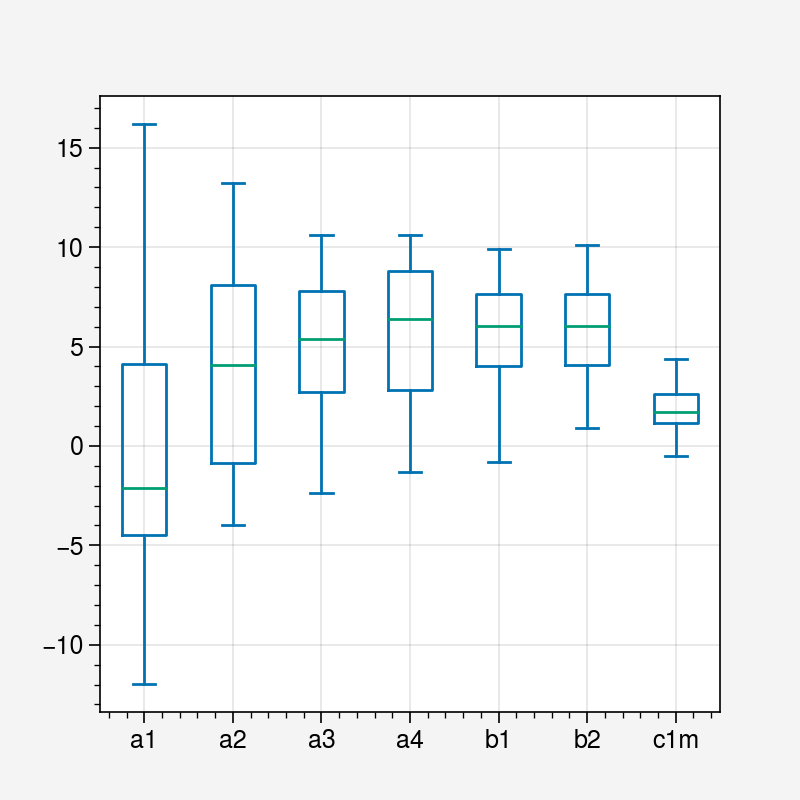

In [173]:
diff_df = results_dict[1000].copy()
diff_df['mask_coverage'] = diff_df['mask'] + "_" + diff_df['coverage_factor'].astype(str)

baseline_framework = "c2m"
baseline = diff_df[diff_df["scenario"]==baseline_framework][['mask_coverage','kWh']].copy()
baseline.set_index("mask_coverage",inplace=True)

diff_result = {}
for framework in frameworks:
    if framework=="c2m":
        pass
    elif framework in ["c1s","c1c","c2s","c2c"]:
        pass
    else:
        test = diff_df[diff_df["scenario"]==framework][['mask_coverage','kWh']].copy()
        test.set_index("mask_coverage",inplace=True)
        # test.sort_index(inplace=True)
        diff_result[framework] = (test - baseline).values.flatten()
    
pd.DataFrame(diff_result).plot.box()

In [ ]:
diff_df = results.copy()
diff_df['mask_coverage'] = diff_df['mask'] + "_" + diff_df['coverage_factor'].astype(str)

baseline_framework = "c2s"
baseline = diff_df[diff_df["scenario"]==baseline_framework][['mask_coverage','kWh']].copy()
baseline.set_index("mask_coverage",inplace=True)

diff_result = {}
for framework in frameworks:
    if framework=="c2s":
        pass
    elif framework in ["c1m","c1c","c2m","c2c"]:
        pass
    else:
        test = diff_df[diff_df["scenario"]==framework][['mask_coverage','kWh']].copy()
        test.set_index("mask_coverage",inplace=True)
        # test.sort_index(inplace=True)
        diff_result[framework] = (test - baseline).values.flatten()
    
pd.DataFrame(diff_result).plot.box()

In [ ]:
diff_df = results.copy()
diff_df['mask_coverage'] = diff_df['mask'] + "_" + diff_df['coverage_factor'].astype(str)

baseline_framework = "c2c"
baseline = diff_df[diff_df["scenario"]==baseline_framework][['mask_coverage','kWh']].copy()
baseline.set_index("mask_coverage",inplace=True)

diff_result = {}
for framework in frameworks:
    if framework=="c2c":
        pass
    elif framework in ["c1m","c1s","c2m","c2s"]:
        pass
    else:
        test = diff_df[diff_df["scenario"]==framework][['mask_coverage','kWh']].copy()
        test.set_index("mask_coverage",inplace=True)
        # test.sort_index(inplace=True)
        diff_result[framework] = (test - baseline).values.flatten()
    
pd.DataFrame(diff_result).plot.box()

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

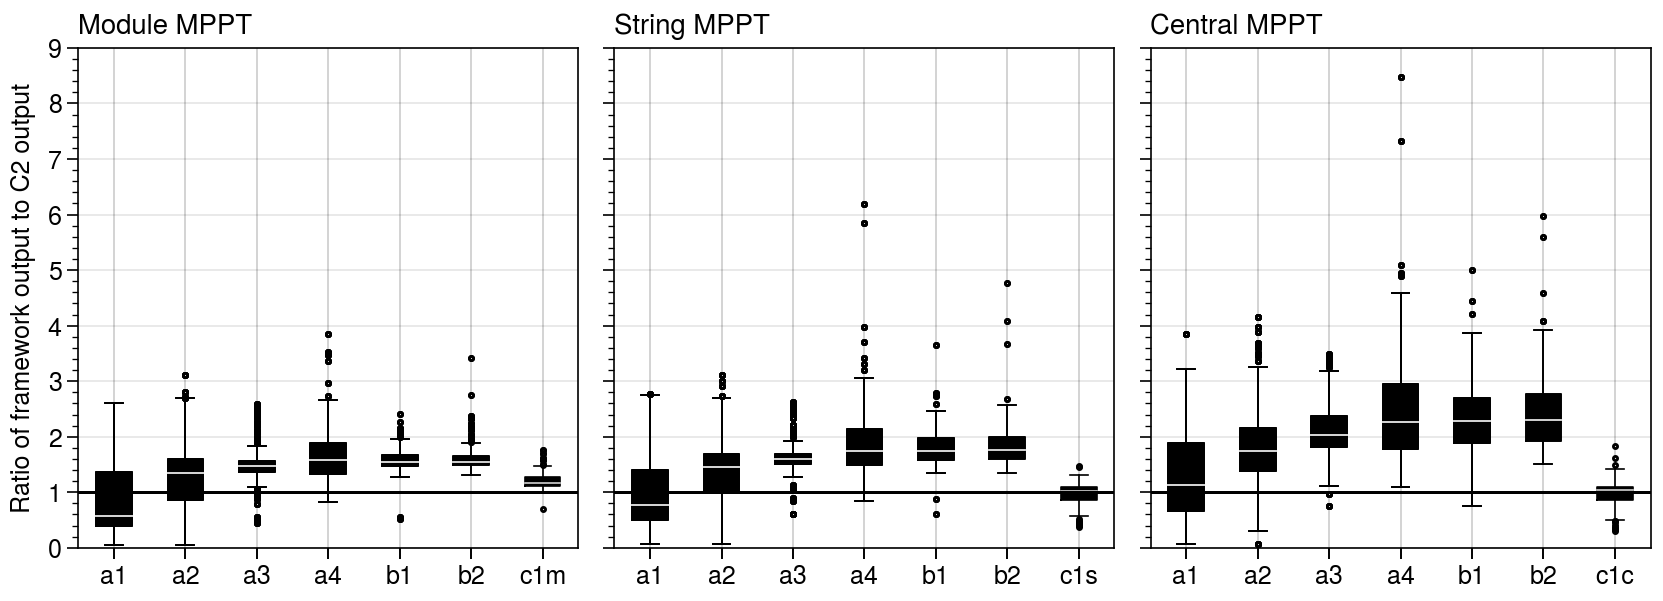

In [251]:
irradiance_level = 1000
fig, axe = pplt.subplots(ncols=3, facecolor="white")


test_diffs = {}
tests = [("c2m", ["c1s","c1c","c2s","c2c"]),
("c2s", ["c1m","c1c","c2m","c2c"]),
("c2c", ["c1m","c1s","c2m","c2s"])]
labels = ['module', 'string', 'central']

for n, test_tuple in enumerate(tests):
    test_framework, passes = test_tuple
    ax = axe[n]
    diff_result = {}
    diff_df = results_dict[irradiance_level].copy()
    diff_df['mask_coverage'] = diff_df['mask'] + "_" + diff_df['coverage_factor'].astype(str)
    baseline_framework = test_framework
    baseline = diff_df[diff_df["scenario"]==baseline_framework][['mask_coverage','kWh']].copy()
    baseline.set_index("mask_coverage",inplace=True)
    
    for framework in frameworks:
        if framework==test_framework:
            pass
        elif framework in passes:
            pass
        else:
            test = diff_df[diff_df["scenario"]==framework][['mask_coverage','kWh']].copy()
            test.set_index("mask_coverage",inplace=True)
            # test.sort_index(inplace=True)
            diff_result[framework] = (test / baseline).values.flatten()
            test_diffs[test_framework] = pd.DataFrame(diff_result)
            
            ax.box(test_diffs[test_framework],fill=True,fc='k',ec="k",markersize=1.5,
                   mediancolor='lightgrey',
                #    boxcolors='red'
                   )
            ax.hlines(1,-1,8,c='k',lw=1,zorder=10)
            ax.format(ltitle=f"{labels[n].capitalize()} MPPT",
                      )
            
axe.format(ylim=(0,9),
           ylocator=1,
           ylabel="Ratio of framework output to C2 output",
           xlim=(-0.5,6.5))

In [252]:
mean_vals = []
for col in test_diffs['c2m'].columns:
    mean_vals.append(test_diffs['c2m'][col].describe()['mean'])
for col in test_diffs['c2s'].columns:
    mean_vals.append(test_diffs['c2s'][col].describe()['mean'])
for col in test_diffs['c2c'].columns:
    mean_vals.append(test_diffs['c2c'][col].describe()['mean'])
np.mean(mean_vals)

1.6169886196221321

In [260]:
plot_var_runtime

,Runtime [sec],Standard Deviation
a1,0.020,0.643246
a2,0.161,0.607939
a3,1.282,0.379838
a4,1.276,0.516028
b1,1.070,0.234713
b2,77.999,0.276380
c1m,1.176,0.156223


scenario
c2m    64.515
Name: runtime [sec], dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

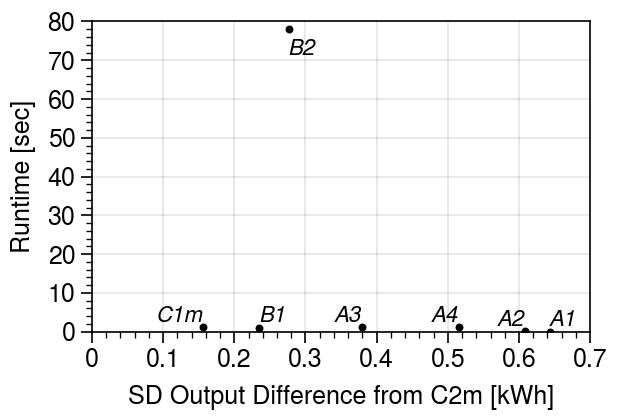

In [287]:
runtime = results[['runtime [sec]','scenario']].groupby("scenario").mean().round(3).loc[["a1","a2","a3","a4","b1","b2","c1m"]]['runtime [sec]']
print(results[['runtime [sec]','scenario']].groupby("scenario").mean().round(3).loc[["c2m"]]['runtime [sec]'])
plot_var_runtime = pd.concat([runtime.rename("Runtime [sec]"),
                              test_diffs['c2m'].describe().loc['std'].rename("Standard Deviation")],axis=1)

fig, axe = pplt.subplots(figsize=(3.1,2.1), facecolor='white')
ax = axe[0]

x_vals = plot_var_runtime['Standard Deviation']
y_vals = plot_var_runtime['Runtime [sec]']
ax.scatter(x=x_vals,
           y=y_vals,
           c='k',
           s=5)

adjust_text = 0.05

for i, label in enumerate(plot_var_runtime.index):
    y_adjust = 0
    if label=='a4':
        ha='right'
    elif label=='a1':
        ha='left'
    elif label=='c1m':
        ha='right'
    elif label=='b1':
        ha='left'
    elif label=='b2':
        y_adjust = -8
    else:
        ha='right'
    ax.text(x_vals[i]+0, y_vals[i]+adjust_text+y_adjust, label.capitalize(), ha=ha, va='bottom',
            size=8,fontstyle='italic')

ax.format(xlim=(0,0.7),
          xlocator=0.1,
          ylim=(0,80),
          ylocator=10,
          xlabel="SD Output Difference from C2m [kWh]")

# Runtime and Difference

In [ ]:
# build test diffs
test_diffs = {}
tests = [("c2m", ["c1s","c1c","c2s","c2c"]),
("c2s", ["c1m","c1c","c2m","c2c"]),
("c2c", ["c1m","c1s","c2m","c2s"])]
labels = ['module', 'string', 'central']

for n, test_tuple in enumerate(tests):
    test_framework, passes = test_tuple
    ax = axe[n]
    diff_result = {}
    diff_df = results.copy()
    diff_df['mask_coverage'] = diff_df['mask'] + "_" + diff_df['coverage_factor'].astype(str)
    baseline_framework = test_framework
    baseline = diff_df[diff_df["scenario"]==baseline_framework][['mask_coverage','kWh']].copy()
    baseline.set_index("mask_coverage",inplace=True)
    
    for framework in frameworks:
        if framework==test_framework:
            pass
        elif framework in passes:
            pass
        else:
            test = diff_df[diff_df["scenario"]==framework][['mask_coverage','kWh']].copy()
            test.set_index("mask_coverage",inplace=True)
            # test.sort_index(inplace=True)
            diff_result[framework] = (test - baseline).values.flatten()
            test_diffs[test_framework] = pd.DataFrame(diff_result)


In [ ]:
pts_per_grid = {"A1":1,
                "A2":12,
                "A3":100,
                "A4":100,
                "B1":84,
                "B2":5040,
                "C1":84,
                "C2":5040}
pd.Series(pts_per_grid)

In [ ]:
# load runtimes and calc mean for each framework
runtimes = results[['runtime [sec]','scenario']].groupby("scenario").mean().round(3).loc[["a1","a2","a3","a4","b1","b2","c1s","c2s"]]
runtimes.index = runtimes.index.str.capitalize().str.strip("s")

runtimes['time per pt [sec]'] = runtimes['runtime [sec]'] / pd.Series(pts_per_grid)
print(runtimes.transpose().to_latex())

# Demonstration Results

In [4]:
# load ecos results
ecos_results = "/Users/jmccarty/Data/230203_ecos_bipv_model/ecos2023_hourly_results.pickle"
with open(ecos_results, "rb") as fp:
    ecos_data = pickle.load(fp)
    
sunup_data = "/Users/jmccarty/Data/230203_ecos_bipv_model/ecos2023_sunup_array.pickle"
with open(sunup_data, "rb") as fp:
    ecos_sunup_array = pickle.load(fp)

In [5]:
## make plot data
time_key = 'H'

plot_dfs = {}

for object_n in [0,1,2]:
    surface_based_results = ecos_data[object_n]['surface_results']
    module_based_results = ecos_data[object_n]['module_results']
    cell_based_results = ecos_data[object_n]['cell_results']
    iv_based_results = ecos_data[object_n]['iv_results']

    names = ["Surface Face", "Module Center", "Cell Center", "Cell IV-Curve"]

    yield_results = []
    irrad_results = []
    irrad_intens_results = []
    efficiency_results = []
    for n,df in enumerate([surface_based_results, module_based_results, cell_based_results, iv_based_results]):
        yield_results.append(df['pmp'].resample(time_key).sum().rename(f"{names[n]}"))
        irrad_results.append(df['irrad'].resample(time_key).sum().rename(f"{names[n]}"))
        irrad_intens_results.append(df['irrad_intens_wm2'].resample(time_key).mean().rename(f"{names[n]}"))
        efficiency_results.append((df['pmp'] / df['irrad']).rename(f"{names[n]}") * 100)

    plot_df = pd.concat(yield_results,axis=1)
    plot_df = plot_df.iloc[ecos_sunup_array]
    
    compare_res = []
    for name in names:
        if name == 'Cell IV-Curve':
            pass
        else:
            diff = plot_df['Cell IV-Curve'] - plot_df[name]
            diff.reset_index(drop=True, inplace=True)

            compare_res.append(pd.DataFrame({name:diff}))
    plot_dfs[ecos_data[object_n]['title']] = pd.concat(compare_res, axis=1)

In [ ]:
def cdf_series(series_data):
    sorted_data = series_data.sort_values()
    sorted_data[len(sorted_data)] = sorted_data.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(sorted_data))
    return pd.Series(cum_dist, index=sorted_data)

def get_color_array_full(n_colors,key):
    colors_arrays = {"Residential Facade":["#e8d8ef","#b6b0c0","#c189a0","#ad6281","#854660","#592f40","#2c1720"],
                    "Commercial Facade":["#dff0e3","#bee1c7","#9ed2ab","#7dc38e","#4ca562","#336e41","#193721"],
                    "Commercial Roof":["#fef3c7","#fde78f","#fcdb56","#fbd120","#cea604","#896f03","#453701"]}

    if n_colors==4:
        return colors_arrays[key][::2]
    else:
        return colors_arrays[key]

In [ ]:
ecos_sunup_array.shape

In [ ]:


fig, axe = pplt.subplots(nrows=3,ncols=1, figsize=(6,6), facecolor='white')

color_array = pplt.get_colors('Greys')[3:3+3]
ls_list = ['solid', (5, (10, 3)), 'dotted']

for n_srf, srf in enumerate(['Commercial Roof', 'Commercial Facade', 'Residential Facade']):
    ax = axe[n_srf]

    for n in [0,1,2]:
        col = list(plot_dfs[srf].columns)[n]
        plot_s = cdf_series(pd.Series(plot_dfs[srf][col].values))
        line_plot_df = pd.DataFrame(plot_s).reset_index().rename(columns={"index":"Difference (Detailed IV Curve - Other Framework) [kWh]", 
                                                                          0:"Probability"})
        
        ax.line(x=line_plot_df['Probability'], 
                y=line_plot_df['Difference (Detailed IV Curve - Other Framework) [kWh]'], 
                label=col, 
                lw=2,
                c=get_color_array_full(4, srf)[n+1],
                ls=ls_list[n],
                legend=False,zorder=10)
        bar_alpha = 0.25
        cmap = 'Greys'
        ax.axvspan(0.0, 0.25, alpha=bar_alpha, color=pplt.get_colors(cmap)[1],zorder=1)
        ax.axvspan(0.25, 0.75, alpha=bar_alpha, color=pplt.get_colors(cmap)[3],zorder=1)
        ax.axvspan(0.75, 1.00, alpha=bar_alpha, color=pplt.get_colors(cmap)[1],zorder=1)
        
        spline_lw = ax.spines['top']._linewidth
        ax.hlines(0,-10,10,c='k',lw=spline_lw)
        ax.format(ltitle=srf)
        
    if n_srf==2:
        hdl, lbl = ax.get_legend_handles_labels()
        
        new_hdl = []
        
        for n_hdl in [0,1,2]:
            hdl_ls = hdl[n_hdl].get_ls()
            hdl_lw = hdl[n_hdl].get_lw()
            new_hdl.append(Line2D([0], [0], color='k', ls=hdl_ls, lw=hdl_lw))
        
    axe.format(xlim=(-0.1,1.1),
               xlocator=0.25,
               ylim=(-5,5),
               ylocator=1)

    
# lgd = fig.legend(loc='r', align='top',
#            labels=lbl, handles=new_hdl, ncols=1, title='Comparison Framework')

axe[0].legend(loc='ul', align='top',frameon=False,
           labels=lbl, handles=new_hdl, ncols=1, title='Comparison Framework')

props = dict(boxstyle='square', facecolor='white', alpha=1.0)

text_string = 'The difference in functional\nunits between the comparison\nframeworks and the proposed\n' + \
              'detailed framework (IV-Curve)\nfor each of the facades. The\n' + \
              'calculated difference is taken at\neach hour when the sun is up.\n' + \
              'We present here the Cumulative\nDistribution Function.\n' + \
              'Difference = IV Curve - Framework'

# fig.text(x=0.805, y=0.07, verticalalignment='bottom', bbox=props,fontsize=7,
#          s=text_string)

fname = "/Users/jmccarty/Nextcloud/Projects/17_framework/results/cdf/demonstrator_absolute_diff_cdf_view.png"
fig.savefig(fname)

In [ ]:


fig, axe = pplt.subplots(nrows=3,ncols=1, figsize=(9,6), facecolor='white')

color_array = pplt.get_colors('Greys')[3:3+3]
ls_list = ['solid', (5, (10, 3)), 'dotted']
mae = {}
for n_srf, srf in enumerate(['Commercial Roof', 'Commercial Facade', 'Residential Facade']):
    ax = axe[n_srf]
    mae[srf] = {}
    for n in [0,1,2]:
        col = list(plot_dfs[srf].columns)[n]
        plot_s = pd.Series(plot_dfs[srf][col].values)
        scatter_plot_df = pd.DataFrame(plot_s).reset_index(drop=True).rename(columns={0:"Difference (Detailed IV Curve - Other Framework) [kWh]"})
        scatter_plot_df['Hour of Year'] = ecos_sunup_array
        mae[srf][col] = scatter_plot_df['Difference (Detailed IV Curve - Other Framework) [kWh]'].abs().mean()
        ax.scatter(x=scatter_plot_df['Hour of Year'], 
                y=scatter_plot_df['Difference (Detailed IV Curve - Other Framework) [kWh]'], 
                label=col, 
                s=0.5,
                c=get_color_array_full(4, srf)[n+1],
                # ls=ls_list[n],
                legend=False,
                zorder=10)
        bar_alpha = 0.15
        cmap = 'Greys'
        ax.axhspan(-5, -4, alpha=bar_alpha, color=pplt.get_colors(cmap)[1],zorder=1)
        ax.axhspan(-4, -3, alpha=bar_alpha, color=pplt.get_colors(cmap)[2],zorder=1)
        ax.axhspan(-3, -2, alpha=bar_alpha, color=pplt.get_colors(cmap)[3],zorder=1)
        ax.axhspan(-2, -1, alpha=bar_alpha, color=pplt.get_colors(cmap)[4],zorder=1)
        ax.axhspan(-1,1, alpha=bar_alpha, color=pplt.get_colors(cmap)[5],zorder=1)
        ax.axhspan(1, 2, alpha=bar_alpha, color=pplt.get_colors(cmap)[4],zorder=1)
        ax.axhspan(2, 3, alpha=bar_alpha, color=pplt.get_colors(cmap)[3],zorder=1)
        ax.axhspan(3, 4, alpha=bar_alpha, color=pplt.get_colors(cmap)[2],zorder=1)
        ax.axhspan(4, 5, alpha=bar_alpha, color=pplt.get_colors(cmap)[1],zorder=1)
        
        # spline_lw = ax.spines['top']._linewidth
        # ax.vlines(0,-1,10000,c='r',lw=spline_lw*2, ls='solid', zorder=100)
        ax.format(ltitle=srf)
        
        
    if n_srf==2:
        hdl, lbl = ax.get_legend_handles_labels()
        
        new_hdl = []
        
        for n_hdl in [0,1,2]:
            el = Line2D([0], [0], marker='o', color='w', label=lbl[n_hdl],
                          markerfacecolor=pplt.get_colors('Greys')[2::3][n_hdl], 
                          markersize=8),
            new_hdl.append(el)
        
    axe.format(xlocator=730,
               xlim=(0,8760),
               ylocator=1,
               ylim=(-5,5),
               )

    
axe[0].legend(loc='ur', ncols=3,
                 labels=lbl, handles=new_hdl, title='Comparison Framework')

props = dict(boxstyle='square', facecolor='white', alpha=1.0)

text_string = 'The difference in functional\nunits between the comparison\nframeworks and the proposed\n' + \
              'detailed framework (IV-Curve)\nfor each of the facades. The\n' + \
              'calculated difference is taken at\neach hour when the sun is up.\n' + \
              'We present here the each the\nvalue at each hour.\n' + \
              'Difference = IV Curve - Framework'

# fig.text(x=0.805, y=0.08, verticalalignment='bottom', bbox=props,fontsize=7,
#          s=text_string)

# fname = "/Users/jmccarty/Data/230203_ecos_bipv_model/notebooks/plots/compare_framework_absolute_diff_hour_view.pdf"
# fig.savefig(fname,dpi=300)

In [ ]:
mae_df = pd.DataFrame(mae).transpose()
srfs = ['Commercial Roof', 'Commercial Facade', 'Residential Facade']
colors = [get_color_array_full(4, srf)[n] for srf in srfs]
fig, axe = pplt.subplots(facecolor='white', figsize=(4.5*1.5,4*1.5))
ax = axe[0]

ax.bar(mae_df, cycle=pplt.get_colors("Greys",10)[3::2])

ax.format(ylabel='Mean Absolute Error',
          ylocator=0.1)

ax.legend(loc="ur",ncols=1)

## Self Consumption

In [ ]:
def calc_self_sufficiency_consumption(demand,generation):
    net_demand = demand - generation
    net_demand_clipped = np.where(net_demand<0,0,net_demand)
    pv_consumed = demand - net_demand_clipped

    self_sufficiency = 100 * (pv_consumed / demand)
    #preinit the array in case generation is zero (np.where does not work with division 0)
    self_consumption = 100 * np.divide(pv_consumed,generation, out=np.zeros_like(pv_consumed), where=generation!=0)
    return self_sufficiency, self_consumption


def calc_self_sufficiency_consumption_single_value(demand, generation):
    if is_pd_series(demand):
        demand = demand.values
    if is_pd_series(generation):
        generation = generation.values

    net_demand = demand - generation
    net_demand_clipped = np.where(net_demand < 0, 0, net_demand)
    pv_consumed = demand - net_demand_clipped

    # self_sufficiency = np.sum(pv_consumed) / np.sum(demand) * 100
    self_sufficiency = round(divide_zero_array(np.sum(pv_consumed), np.sum(demand)) * 100,3)
    # self_consumption = np.sum(pv_consumed) / np.sum(generation) * 100
    self_consumption = round(divide_zero_array(np.sum(pv_consumed), np.sum(generation)) * 100,3)

    return self_sufficiency, self_consumption

def divide_zero_array(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

def is_pd_series(variable):
    return isinstance(variable, pd.Series)

In [ ]:
electricty_demand_data_fp = "demonstration_electrcity_demand.csv"
demand = pd.read_csv(electricty_demand_data_fp,skiprows=1,parse_dates=['Unnamed: 0'])
demand.index = pd.to_datetime(demand["Unnamed: 0"].values, format="%d.%m.%Y %H:%M")
del demand['Unnamed: 0']

build_name_dict = pd.read_csv(electricty_demand_data_fp)
del build_name_dict['Unnamed: 0']
build_name_dict = dict(zip(build_name_dict.loc[0].astype(int),build_name_dict.columns))
build_name_dict


In [ ]:
idx = 1
framework = "surface_results"
# hourly
demand_s = demand[str(idx)]
gen_s = ecos_data[idx][framework]['pmp']
ss, sc = calc_self_sufficiency_consumption_single_value(demand_s, gen_s)
print(ss, sc)
# monthly
demand_s = demand[str(idx)].resample("M").sum()
gen_s = ecos_data[idx][framework]['pmp'].resample("M").sum()
ss, sc = calc_self_sufficiency_consumption_single_value(demand_s, gen_s)
print(ss, sc)

In [ ]:
idx = 1
frameworks = ["surface_results", "module_results", "cell_results", "iv_results"]
for framework in frameworks:
    print(framework)
    # hourly
    demand_s = demand[str(idx)]
    gen_s = ecos_data[idx][framework]['pmp']
    ss, sc = calc_self_sufficiency_consumption_single_value(demand_s, gen_s)
    print(" - hourly", ss, sc)
    # monthly
    demand_s = demand_s.resample("M").sum()
    gen_s = gen_s.resample("M").sum()
    ss, sc = calc_self_sufficiency_consumption_single_value(demand_s, gen_s)
    print(" - monthly", ss, sc)

In [ ]:
ecos_data[0]['module_results']['pmp'].sum()

ecos_data[0]['module_results']['pmp'].sum()

# Carbon Curves

In [6]:
def projected_output(production_values, lifetime, max_performance=100, annual_factor=0.54, min_performance=80):
    derate_factors = np.linspace(max_performance,
                                 max_performance - (lifetime * annual_factor),
                                 num=lifetime).reshape(-1, 1)
    derate_factors = np.clip(derate_factors, min_performance, None) / 100
    lifetime_production = production_values * derate_factors
    return lifetime_production.flatten().sum()

In [7]:
emissions_data_fp = glob.glob(os.path.join("ch_emissions","*.csv"))
emissions_all = pd.DataFrame([pd.read_csv(fp)['Carbon Intensity gCO₂eq/kWh (direct)'].rename(fp.split(os.sep)[1].split("_")[1]) for fp in emissions_data_fp]).transpose()
ghg_kwh = emissions_all.mean(axis=1)

# ecos_data[0]['module_results']

In [96]:
input_data = ecos_data[0]['surface_results']

kgco2e_m2 = 245
lifetime = 25


def calculate_carbon_curve(input_data, lifetime=25, kgco2_m2=245):
    """_summary_

    Args:
        input_data (pd.DataFrame): contains ['irrad','irrad_intens_wm2','pmp',]
        lifetime (int, optional): _description_. Defaults to 25.
        kgco2_m2 (int, optional): _description_. Defaults to 245.

    Returns:
        _type_: _description_
    """
    # get area
    area = input_data[input_data['irrad']>0].apply(lambda x: x['irrad']*1000 / x['irrad_intens_wm2'], axis=1).iloc[0]

    # convert to kwh/m2
    xvals=input_data['irrad_intens_wm2'] / 1000
    yvals=input_data['pmp'] 

    # need to build a range of x values for annual irradiance (kwh/m2)
    new_x = np.linspace(1,1000, 1000).reshape(-1,1)

    # reshape
    x_r = xvals.to_numpy()
    x_r[0] = 0
    x_r = x_r.reshape(-1,1)
    y_r = yvals.to_numpy()
    print(y_r)
    y_r[0] = 0
    y_r = y_r.reshape(-1,1)
    

    # linear regression of input data
    reg = LinearRegression().fit(x_r, y_r)

    # predict output using model
    new_y = reg.predict(new_x)

    # use the modeled data to calculate the lifetime output for each input irradiance step
    # kwh
    production = pd.Series(new_y.flatten()).apply(lambda x: projected_output(x, lifetime))

    # calc emboided carbon
    # kgCO2e
    system_carbon = area * kgco2e_m2

    # calculate kgCO2e / kwh/m2
    system_carbon_factor = system_carbon / production

    return system_carbon_factor

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

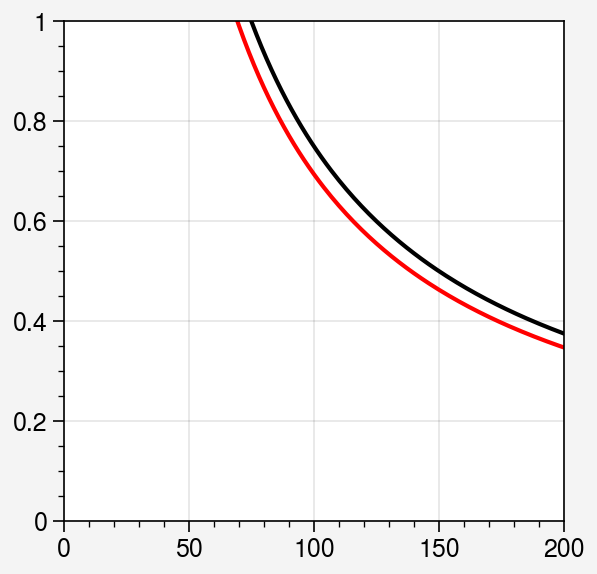

In [97]:
irrad_x = np.linspace(1,1000, 1000)
idx = 1

curve_a = calculate_carbon_curve(ecos_data[idx]['surface_results'])
curve_b = calculate_carbon_curve(ecos_data[idx]['iv_results'])

fig, axe = pplt.subplots()

ax = axe[0]

ax.line(x=irrad_x.flatten(),
           y=curve_a,
           c="k")

ax.line(x=irrad_x.flatten(),
           y=curve_b,
           c="red")

ax.format(xlim=(0,200),
          ylim=(0,1)
          )

In [23]:
curve_b

0      1.101391
1      0.550466
2      0.366926
3      0.275176
4      0.220131
         ...   
995    0.001105
996    0.001104
997    0.001103
998    0.001102
999    0.001100
Length: 1000, dtype: float64

<a list of 1 Line2D objects>

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

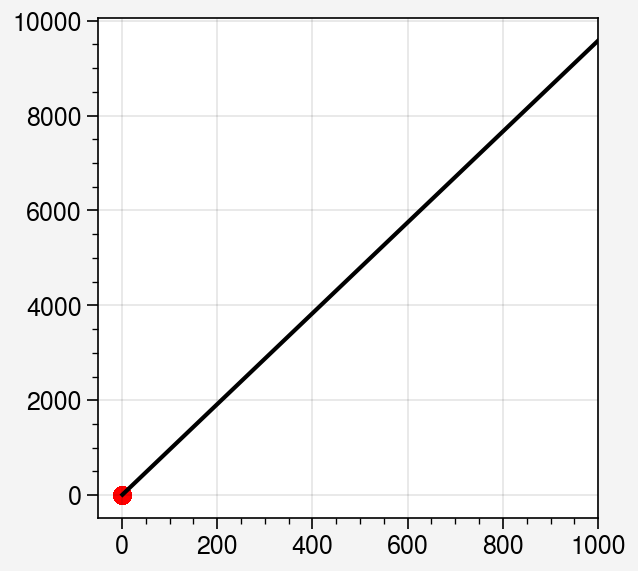

In [98]:
input_data = ecos_data[0]['surface_results']
# get area
area = input_data[input_data['irrad']>0].apply(lambda x: x['irrad']*1000 / x['irrad_intens_wm2'], axis=1).iloc[0]

# convert to kwh/m2
xvals=input_data['irrad_intens_wm2'] / 1000
yvals=input_data['pmp']

# need to build a range of x values for annual irradiance (kwh/m2 per year)
new_x = np.linspace(1,1000, 1000).reshape(-1,1)

# reshape
x_r = xvals.to_numpy()
x_r[0] = 0
x_r = x_r.reshape(-1,1)
y_r = yvals.to_numpy()
y_r[0] = 0
y_r = y_r.reshape(-1,1)


# linear regression of input data
reg = LinearRegression().fit(x_r, y_r)

# predict output using model
new_y = reg.predict(new_x)

fig, axe = pplt.subplots()

ax = axe[0]

ax.scatter(x=x_r,
           y=y_r,
           c="r")

ax.line(x=new_x.flatten(),
        y=new_y.flatten(),
        c="k")



In [99]:
ecos_data[0].keys()

dict_keys(['surfaces', 'title', 'surface_results', 'module_results', 'cell_results', 'iv_results'])

Commercial Roof
 - surface_results: [89.43] 1.04 x baseline [86.24]
 - module_results: [50.15] 0.58 x baseline [86.24]
 - cell_results: [68.55] 0.79 x baseline [86.24]
Commercial Facade
 - surface_results: [89.05] 1.06 x baseline [84.36]
 - module_results: [65.09] 0.77 x baseline [84.36]
 - cell_results: [78.57] 0.93 x baseline [84.36]
Residential Facade
 - surface_results: [90.81] 0.93 x baseline [97.4]
 - module_results: [74.99] 0.77 x baseline [97.4]
 - cell_results: [90.47] 0.93 x baseline [97.4]


<AxesSubplot:ylabel='Ratio of Framework System Carbon Intensity to IV-Curve'>

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/

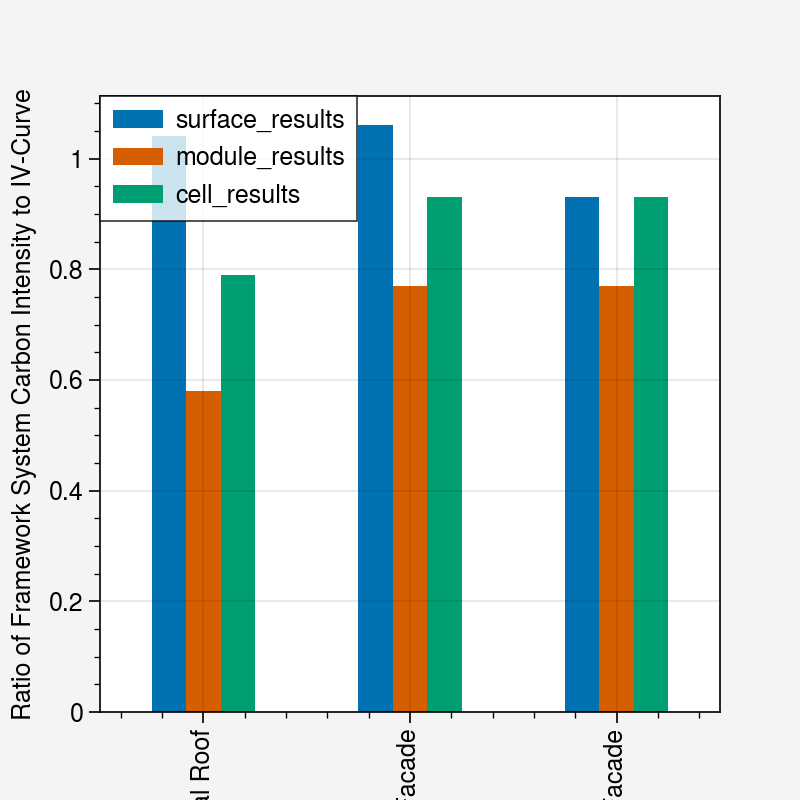

In [127]:
input_data = ecos_data[0]['surface_results']

kgco2e_m2 = 245
lifetime = 25


def calculate_carbon_intensity(input_data, lifetime=25, kgco2_m2=245):
    # get area
    area = input_data[input_data['irrad']>0].apply(lambda x: x['irrad']*1000 / x['irrad_intens_wm2'], axis=1).iloc[0] #m2
    annual_production = input_data['pmp'].sum() #kWh
    lifetime_production = pd.Series(annual_production).apply(lambda x: projected_output(x, lifetime)) #kWh
    
    system_carbon = area * kgco2e_m2 #kgCO2e

    # calculate kgCO2e / kwh/m2
    system_carbon_factor = system_carbon / lifetime_production #kgCO2e / kWh
    return round(system_carbon_factor[0] * 1000, 2)

carbon_intensity_plot = {}

for idx in [0,1,2]:
    print(ecos_data[idx]['title'])
    carbon_baseline = calculate_carbon_intensity(ecos_data[idx]["iv_results"])
    carbon_intensity_plot[ecos_data[idx]['title']] = {}
    for model in ['surface_results', 'module_results', 'cell_results']:
        carbon_test = calculate_carbon_intensity(ecos_data[idx][model])
        carbon_ratio = round(carbon_test / carbon_baseline,2)
        print(f" - {model}: [{carbon_test}] {carbon_ratio} x baseline [{carbon_baseline}]")
        carbon_intensity_plot[ecos_data[idx]['title']][model] = carbon_ratio
        
pd.DataFrame(carbon_intensity_plot).transpose().plot.bar(ylabel='Ratio of Framework System Carbon Intensity to IV-Curve')

In [161]:
def calculate_performance_ratio(annual_production, annual_irradiance, nominal_efficiency):
    """_summary_

    Args:
        annual_production (float): actual electricity produced by the system in one year [kWh]
        annual_irradiance (float): radiation received by the system in one year [kWh] 
        system_area (float): total area of the system devices [m2]
        nominal_efficiency (float): the efficieny of the device under STC [no unites 0.00-1.00]

    Returns:
        _type_: _description_
    """
    expected_production = annual_irradiance * nominal_efficiency
    return round(annual_production / expected_production,2)


def projected_output(first_year_production, lifetime, max_performance=100, annual_factor=0.54, min_performance=80):
    """_summary_

    Args:
        first_year_production (float): _description_
        lifetime (int): _description_
        max_performance (int, optional): maximum potential performance in the system. Defaults to 100.
        annual_factor (float, optional): annual loss factor for performance. Defaults to 0.54.
        min_performance (int, optional): where performance loss flattens out. Defaults to 80.

    Returns:
        _type_: _description_
    """
    # generate list of annual system performance factors
    derate_factors = np.linspace(max_performance,
                                 max_performance - (lifetime * annual_factor),
                                 num=lifetime).reshape(-1, 1)
    
    # clip to prevent runaways
    derate_factors = np.clip(derate_factors, min_performance, None) / 100
    
    # calc production for each year given the derate values
    lifetime_production = first_year_production * derate_factors
    
    # return the lifetime sum
    return lifetime_production.flatten().sum()

def calc_system_carbon_intensity(pv_embodied_carbon, effective_irradiance, device_efficiency, performance_ratio, system_area, device_lifetime, self_consumption):
    """_summary_

    Args:
        pv_embodied_carbon (float): the embodied cabron associated with the PV device [kgCO2e/m2]
        effective_irradiance (float): how much irradiance is the system receives in one year [kWh/m2 per annum]
        device_efficiency (float): the efficiency of the PV device [no units 0.00-1.00]
        performance_ratio (float): the ratio factor that represents losses in the system [no units 0.00-1.00]
        system_area (float): how much area is the system covering [m2]
        device_lifetime (int): the expected lifetime of the system [years]
        self_consumption (float): how much of the generated electricity is attributabel to avoided emissions [no units 0.00-1.00]

    Returns:
        _type_: _description_
    """
    # calcualte the first years production
    year_one_production = effective_irradiance * device_efficiency * performance_ratio * system_area
    
    # using the lienar derate model calcualte the lifetime production of the system
    lifetime_generation = projected_output(year_one_production, device_lifetime)
    
    # return the system carbon intensity
    # kgCO2e/kWh
    return (pv_embodied_carbon * system_area) / (lifetime_generation * self_consumption)

In [250]:



calculate_performance_ratio(ecos_data[1]['surface_results']['pmp'].sum(), 
                            ecos_data[1]['surface_results']['irrad'].sum(), 
                            0.155)

0.87